# A Simulação de Monte Carlo e Séries Temporais para Modelagem Financeira

### Importando bibliotecas e defindo configurações

In [1]:
# Importando a biblioteca da YahooFinance para baixar cotações
# Caso não tenha instalado esse pacote, basta digitar !pip3 install yfinance
import yfinance as yf

# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para cálculos estatísticos
import scipy
# from scipy.stats import kurtosis, skew, shapiro

import warnings
warnings.filterwarnings('ignore')

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# Formatando valores com duas casas decimais
pd.options.display.float_format = '{:.2f}'.format

### Carregando os Dados

In [9]:
# Carrega o dataset
# dados = pd.read_csv('dados.csv', parse_dates = True, index_col = 'Data)

Cotacoes = yf.Ticker("BTC-USD")

# Opções de períodos: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd.
dados = Cotacoes.history(period='1y')
dados.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-10-17 00:00:00+00:00,19268.56,19635.80,19173.33,19550.76,27472552998,0.00,0.00
2022-10-18 00:00:00+00:00,19550.47,19666.99,19144.77,19334.42,30580012344,0.00,0.00
2022-10-19 00:00:00+00:00,19335.03,19348.42,19127.69,19139.54,22425387184,0.00,0.00
2022-10-20 00:00:00+00:00,19138.09,19315.20,18971.46,19053.74,24493974420,0.00,0.00
2022-10-21 00:00:00+00:00,19053.20,19237.38,18770.97,19172.47,32459287866,0.00,0.00


In [10]:
dados.drop('Dividends', axis=1, inplace=True)
dados.drop('Stock Splits', axis=1, inplace=True)
dados.columns = ['Abertura', 'Maximo', 'Minimo', 'Fechamento', 'Volume']
dados.head()

,Abertura,Maximo,Minimo,Fechamento,Volume
Date,,,,,
2022-10-17 00:00:00+00:00,19268.56,19635.80,19173.33,19550.76,27472552998
2022-10-18 00:00:00+00:00,19550.47,19666.99,19144.77,19334.42,30580012344
2022-10-19 00:00:00+00:00,19335.03,19348.42,19127.69,19139.54,22425387184
2022-10-20 00:00:00+00:00,19138.09,19315.20,18971.46,19053.74,24493974420
2022-10-21 00:00:00+00:00,19053.20,19237.38,18770.97,19172.47,32459287866


In [11]:
# Vamos observar o nosso range de dados
print(f'Menor data: {dados.index.min()}')
print(f'Maior data: {dados.index.max()}')

Menor data: 2022-10-17 00:00:00+00:00
Maior data: 2023-10-17 00:00:00+00:00


In [12]:
# Vamos observar os dados referentes à última data do no sso conjunto de dados
# Utilizaremos esses dados mais adiante para compor os parâmetros da simulação de Monte Carlo.
display(dados.loc[dados.index.max()])

Abertura           28540.67
Maximo             28551.83
Minimo             28130.13
Fechamento         28449.88
Volume       25972101120.00
Name: 2023-10-17 00:00:00+00:00, dtype: float64

In [13]:
# Calculando o percentual de mudança na cotação de fechamento diário das ações
# Ou seja, quanto o valor de fechamento varia de um dia para outro, o retorno diário da ação.
retorno_diario = dados['Fechamento'].pct_change().dropna()
retorno_diario.head()

Date
2022-10-18 00:00:00+00:00   -0.01
2022-10-19 00:00:00+00:00   -0.01
2022-10-20 00:00:00+00:00   -0.00
2022-10-21 00:00:00+00:00    0.01
2022-10-22 00:00:00+00:00    0.00
Name: Fechamento, dtype: float64

In [14]:
dados = pd.merge(dados, retorno_diario, how='inner', on='Date')
dados.columns = ['Abertura', 'Maximo', 'Minimo', 'Fechamento', 'Volume', 'Variacao_Diaria']
dados.head()

,Abertura,Maximo,Minimo,Fechamento,Volume,Variacao_Diaria
Date,,,,,,
2022-10-18 00:00:00+00:00,19550.47,19666.99,19144.77,19334.42,30580012344,-0.01
2022-10-19 00:00:00+00:00,19335.03,19348.42,19127.69,19139.54,22425387184,-0.01
2022-10-20 00:00:00+00:00,19138.09,19315.20,18971.46,19053.74,24493974420,-0.00
2022-10-21 00:00:00+00:00,19053.20,19237.38,18770.97,19172.47,32459287866,0.01
2022-10-22 00:00:00+00:00,19172.38,19248.07,19132.24,19208.19,16104440957,0.00


In [15]:
# Visualizando registros
# Cada coluna representa o valor da ação em cada dia da série.
# valor de abertura, fechamento, máximo, mínimo, volume e variação diária sobre o fechamento.
dados.head()

,Abertura,Maximo,Minimo,Fechamento,Volume,Variacao_Diaria
Date,,,,,,
2022-10-18 00:00:00+00:00,19550.47,19666.99,19144.77,19334.42,30580012344,-0.01
2022-10-19 00:00:00+00:00,19335.03,19348.42,19127.69,19139.54,22425387184,-0.01
2022-10-20 00:00:00+00:00,19138.09,19315.20,18971.46,19053.74,24493974420,-0.00
2022-10-21 00:00:00+00:00,19053.20,19237.38,18770.97,19172.47,32459287866,0.01
2022-10-22 00:00:00+00:00,19172.38,19248.07,19132.24,19208.19,16104440957,0.00


In [16]:
# Tipos de Dados
dados.dtypes

Abertura           float64
Maximo             float64
Minimo             float64
Fechamento         float64
Volume               int64
Variacao_Diaria    float64
dtype: object

In [17]:
# Shape
dados.shape

(365, 6)

In [18]:
# Sumário estatístico
dados.describe()

,Abertura,Maximo,Minimo,Fechamento,Volume,Variacao_Diaria
count,365.00,365.00,365.00,365.00,365.00,365.00
mean,24618.63,24993.33,24275.89,24643.50,20199582180.04,0.00
std,4590.46,4656.04,4535.82,4588.64,12780400185.57,0.02
min,15782.30,16253.05,15599.05,15787.28,5331172801.00,-0.14
25%,20924.62,21345.38,20566.48,20976.30,12175322951.00,-0.01
50%,26245.21,26618.00,25880.60,26256.83,16493186997.00,-0.00
75%,28087.18,28532.83,27588.50,28168.09,24999983362.00,0.01
max,31474.72,31814.52,30659.36,31476.05,118992465607.00,0.11


### Visualizando o Preço Diário de Fechamento das Ações no Tempo

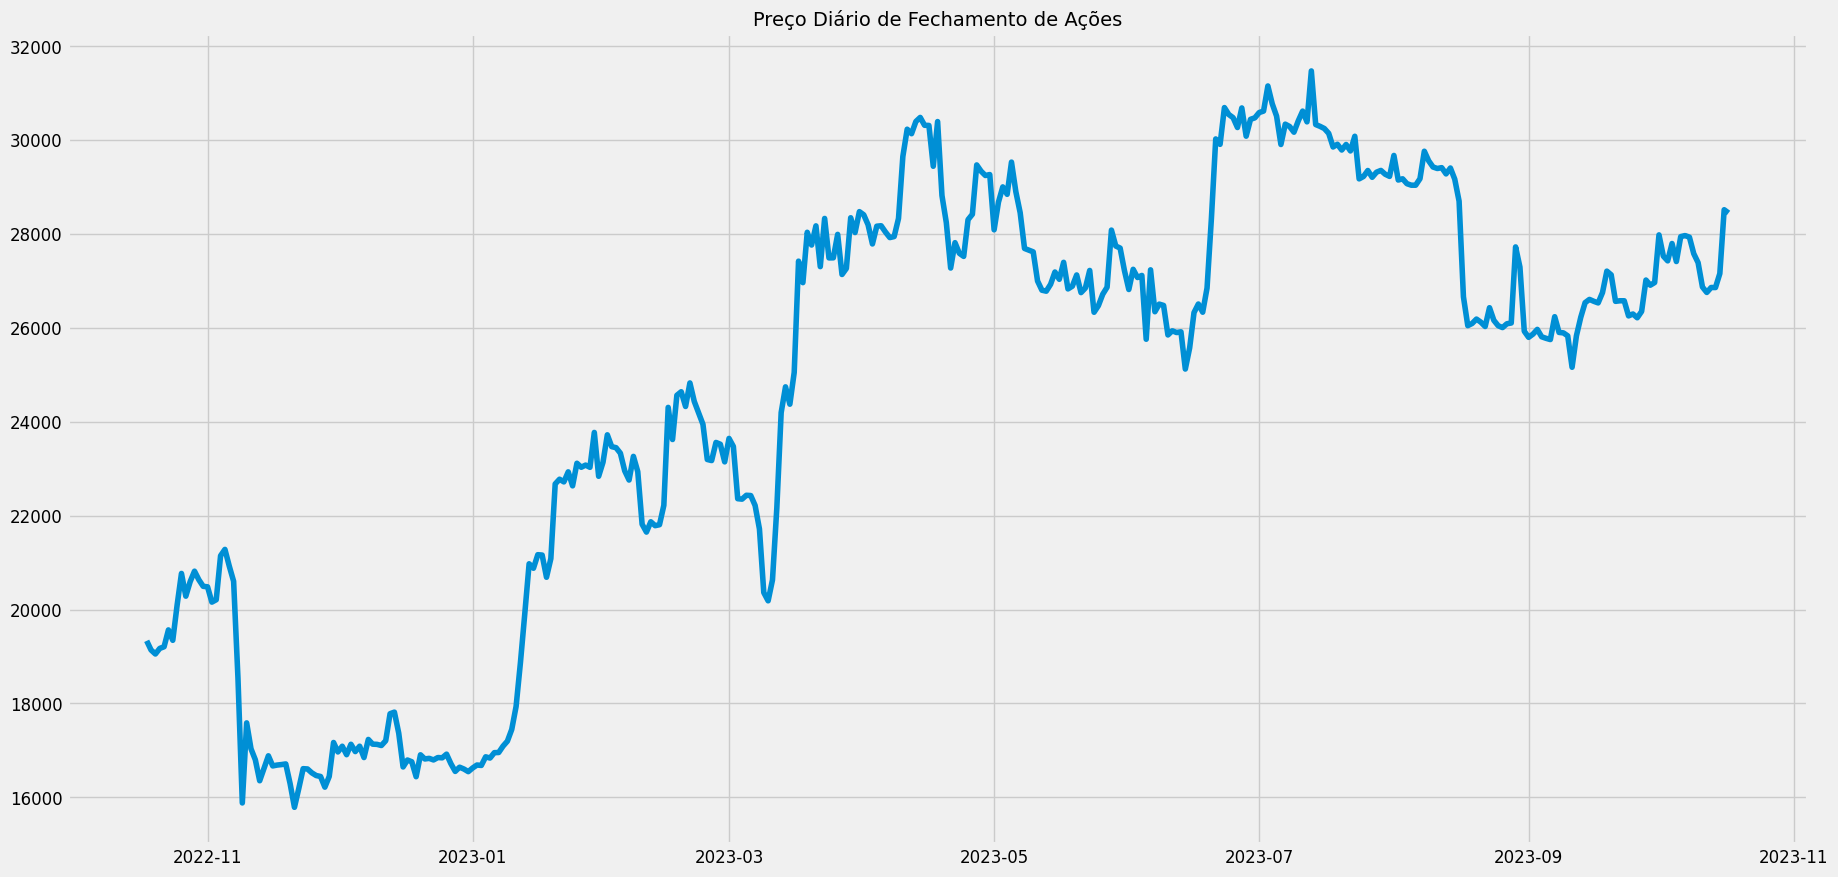

In [19]:
# Plot
plt.plot(dados['Fechamento'])
plt.title('Preço Diário de Fechamento de Ações', size=14)
plt.show()

In [25]:
# Retorno acumulado
retorno_diario_acumulado = (1 + retorno_diario).cumprod() - 1
retorno_diario_acumulado.max()

0.6099656662925081

#### Análise Exploratória e Estatística Descritiva

Vamos usar a estatística para calcular o retorno médio e a variação (desvio padrão).

In [22]:
# Média do fechamento diário da cotação das ações
media_retorno_diario = np.mean(retorno_diario)

In [23]:
# Desvio padrão do fechamento diário da cotação e ações
desvio_retorno_diario = np.std(retorno_diario)

In [27]:
# Média e desvio padrão
print(f'Média do Retorno de Fechamento: {media_retorno_diario}')
print(f'Desvio padrão do Retorno de Fechamento: {desvio_retorno_diario}')

Média do Retorno de Fechamento: 0.0013191107061764934
Desvio padrão do Retorno de Fechamento: 0.02411589504044429


Vamos considerar o ano com 364 dias de funcionamento por ser um criptoativo. Caso seja uma ação normal, devemos considerar 252 dias do ano, pois a operação de ações ocorre somente de segunda a sexta.

In [31]:
# Média e desvio padrão no ano (considerando 364 dias de operações)
print(f'Retorno Médio Analizado de Fechamento: {(1 + media_retorno_diario) ** 364 - 1}')
print(f'Desvio Padrão Anualizado de Fechamento: {desvio_retorno_diario * np.sqrt(364)}')

Retorno Médio Analizado de Fechamento: 0.6158156661499181
Desvio Padrão Anualizado de Fechamento: 0.4601019531267261


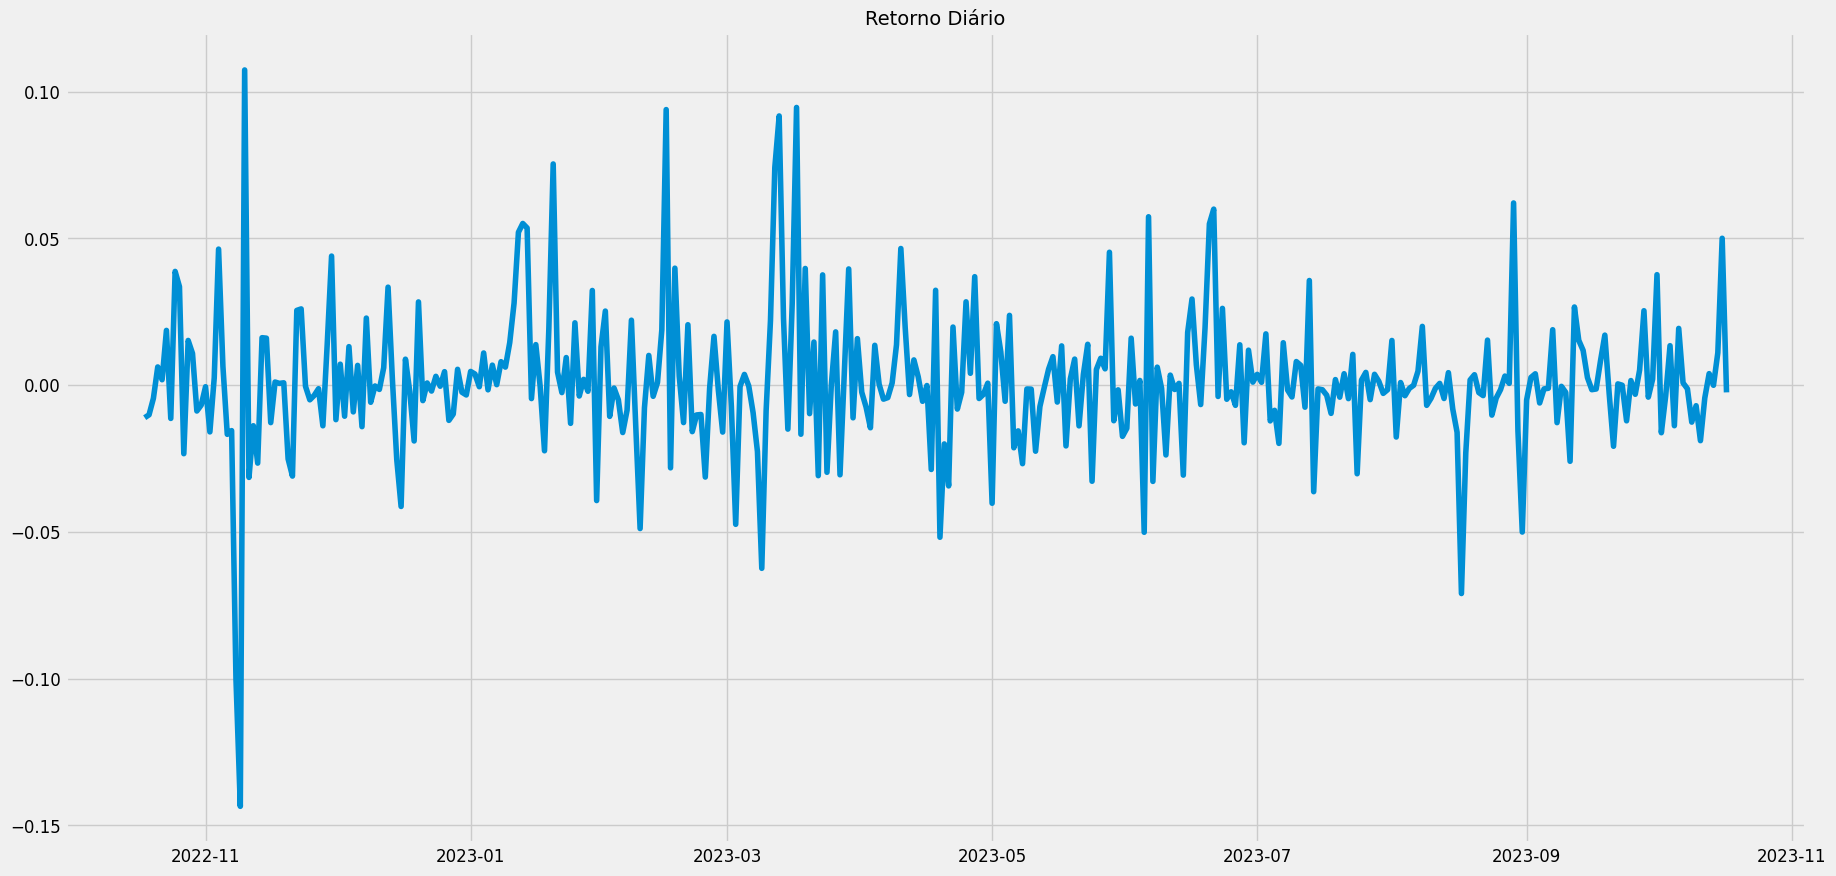

In [32]:
# Plot
plt.plot(retorno_diario)
plt.title('Retorno Diário', size=14)
plt.show()

Com apenas duas grandes variações, o retorno diário tem sido constante ao longo do tempo. Vamos criar um histograma com a distribuição do retorno diário.

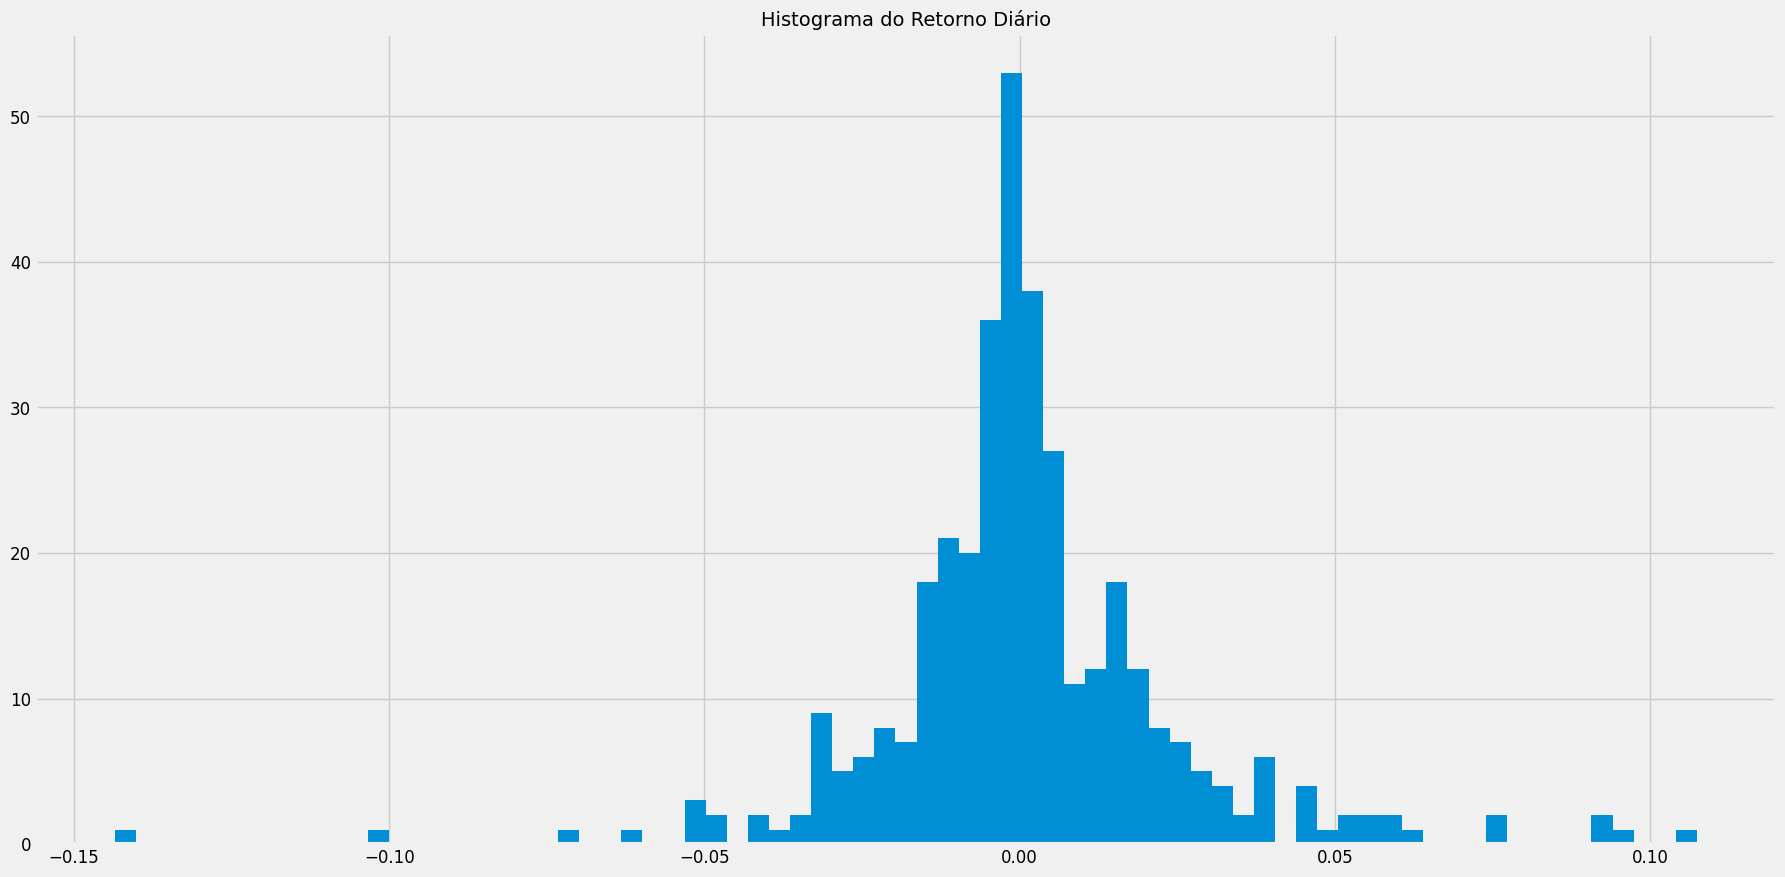

In [33]:
# Plot
plt.hist(retorno_diario, bins=75)
plt.title('Histograma do Retorno Diário', size=14)
plt.show()

Os valores estão bem próximos da média.

In [34]:
# Transformação de log e diferenciação para cálculo do retorno diário
log_retorno_diario = (np.log(dados['Fechamento']) - np.log(dados['Fechamento']).shift(-1)).dropna()

# Calculando média e desvio padrão após transformação
log_media_retorno_diario = np.mean(log_retorno_diario)
log_desvio_retorno_diario = np.std(log_retorno_diario)

Vamos criar um plot com o retorno diário da série transformada.

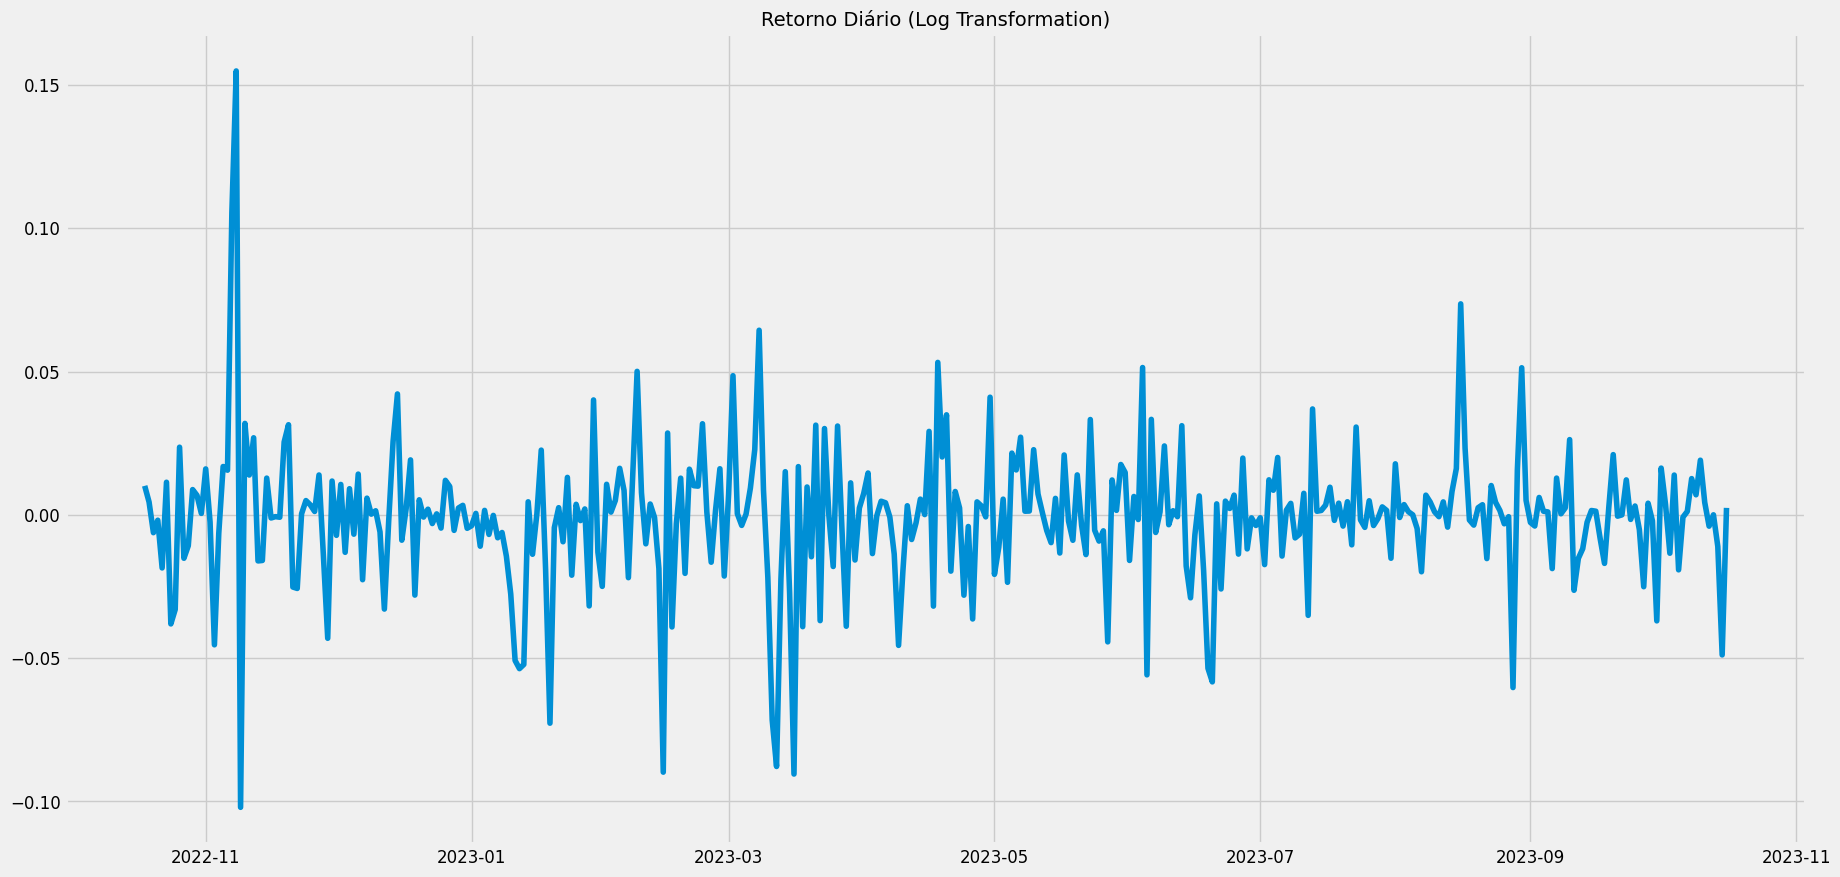

In [35]:
# Plot
plt.plot(log_retorno_diario)
plt.title('Retorno Diário (Log Transformation)', size=14)
plt.show()

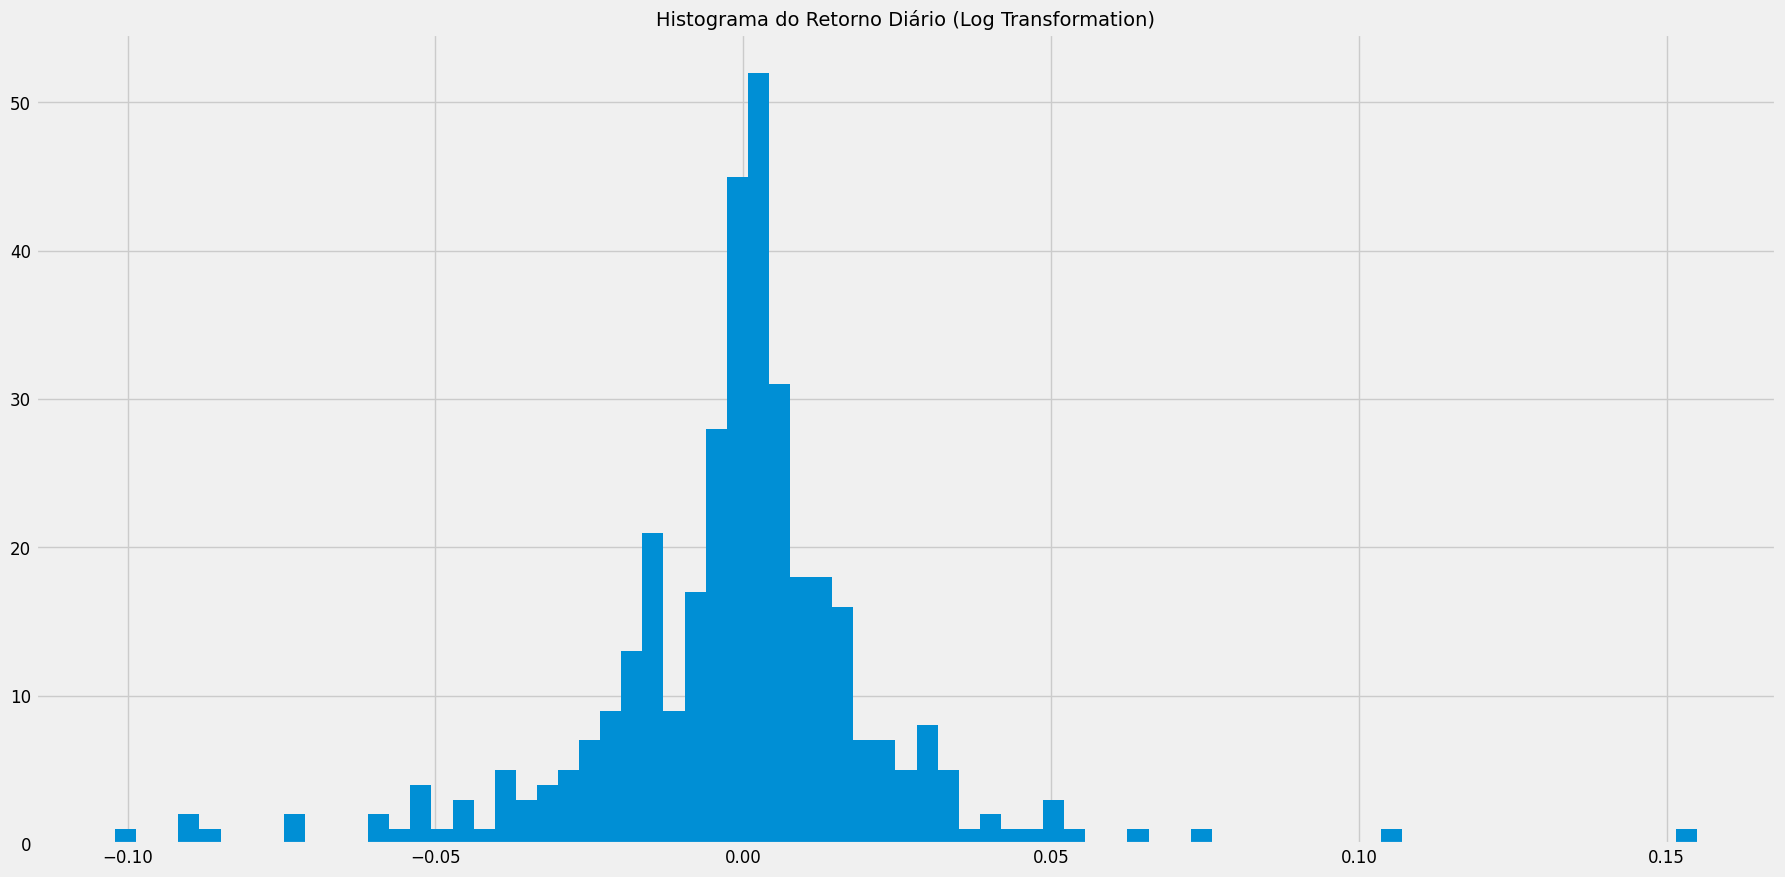

In [36]:
# Plot
plt.hist(log_retorno_diario, bins=75)
plt.title('Histograma do Retorno Diário (Log Transformation)', size=14)
plt.show()

#### Valor Histórico

Vamos calcular o valor histórico do preço da ação.

In [37]:
# Nível de variãncia
var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
print(f'Certeza de que as perdas diárias não excederão o VaR% em um determinado dia com base em valores históricos.')
print(f'VAR 95%: {var}')

Certeza de que as perdas diárias não excederão o VaR% em um determinado dia com base em valores históricos.
VAR 95%: -0.03909218887172923


In [38]:
# Var para os próximo 5 dias
var * np.sqrt(5)

-0.08741279170644738

#### Valor Histórico Condicional

In [39]:
# Nível de variância
var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
cvar = log_retorno_diario[log_retorno_diario < var].mean()
print(f'Nos piores 5% dos casos, as perdas foram, em média, superiores ao percentil histórico.')
print(f'CVAR 95%: {cvar}')

Nos piores 5% dos casos, as perdas foram, em média, superiores ao percentil histórico.
CVAR 95%: -0.06131676024249724


#### Monte Carlos simulation

In [47]:
# Simulação de Monte Carlo

# Número de dias a frente
dias_posteriores = 180

# Número de simulações
simulacoes = 2500

# Último valor da ação
ultimo_preco = 28449.88

# Criar um array vazio com as dimensões
results = np.empty((simulacoes, dias_posteriores))

# Loop por cada simulação
for s in range(simulacoes):

    # Calcula o retorno com dados randômicos seguindo uma distribuição normal
    random_returns = 1 + np.random.normal(loc=log_media_retorno_diario, scale=log_desvio_retorno_diario, size=dias_posteriores)

    result = ultimo_preco * (random_returns.cumprod())

    results[s, :] = result

In [48]:
# Definindo o índice da série simulada
index = pd.date_range('2023-10-18', periods=dias_posteriores, freq='D')
resultados = pd.DataFrame(results.T, index=index)
media_resultados = resultados.apply('mean', axis=1)

#### Resultado da Simulação de Monte Carlo

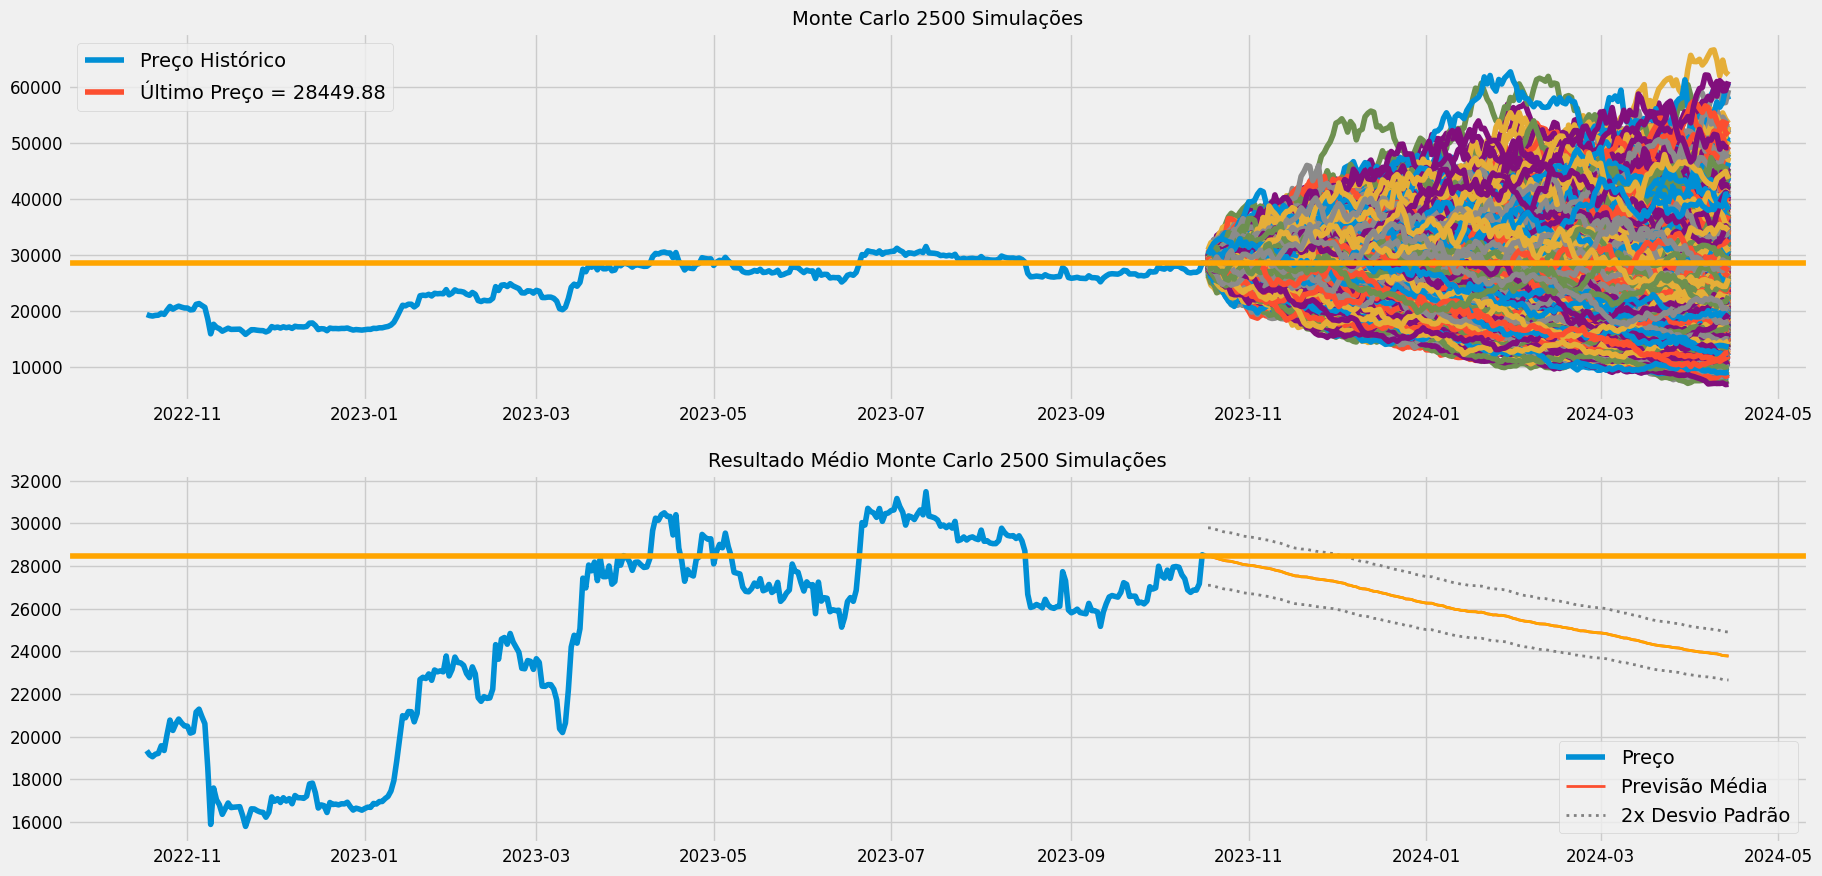

In [49]:
# Dividindo a área de plotagem em 2 subplots
fig, ax = plt.subplots(nrows= 2, ncols= 1)

# Plot
ax[0].plot(dados['Fechamento'][:'2024-04-30'])
ax[0].plot(resultados)
ax[0].axhline(28449.88, c='orange')
ax[0].set_title(f'Monte Carlo {simulacoes} Simulações', size=14)
ax[0].legend(['Preço Histórico', 'Último Preço = 28449.88'])

ax[1].plot(dados['Fechamento'][:'2024-04-30'])
ax[1].plot(resultados.apply('mean', axis=1), lw=2)
ax[1].plot(media_resultados.apply((lambda x: x * (1 + 1.96 * log_desvio_retorno_diario))), lw=2, linestyle='dotted', c='gray')
ax[1].plot(media_resultados, lw=2, c='orange')
ax[1].plot(media_resultados.apply((lambda x: x * (1 - 1.96 * log_desvio_retorno_diario))), lw=2, linestyle='dotted', c='gray')
ax[1].axhline(28449.88, c='orange')
ax[1].set_title(f'Resultado Médio Monte Carlo {simulacoes} Simulações', size=14)
ax[1].legend(['Preço', 'Previsão Média', '2x Desvio Padrão'])

plt.show()